In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms,datasets
from net import Net
from train import train
from scipy import optimize 

## Train Model 

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
model = Net()

In [4]:
#train()

## stAdv Attack 

In [5]:
#https://github.com/rakutentech/stAdv - refered code
def flow_st(images,flows):
    images_shape = images.size()
    flows_shape = flows.size()
    batch_size = images_shape[0]
    H = images_shape[2]
    W = images_shape[3]
    basegrid = torch.stack(torch.meshgrid(torch.arange(0,H), torch.arange(0,W))) #(2,H,W)
    sampling_grid = basegrid.unsqueeze(0).type(torch.float32).to(device) + flows.to(device)
    sampling_grid_x = torch.clamp(sampling_grid[:,1],0.0,W-1.0).type(torch.float32)
    sampling_grid_y = torch.clamp(sampling_grid[:,0],0.0,H-1.0).type(torch.float32)
    
    x0 = torch.floor(sampling_grid_x).type(torch.int64)
    x1 = x0 + 1
    y0 = torch.floor(sampling_grid_y).type(torch.int64)
    y1 = y0 + 1
    
    x0 = torch.clamp(x0, 0, W - 2)
    x1 = torch.clamp(x1, 0, W - 1)
    y0 = torch.clamp(y0, 0, H - 2)
    y1 = torch.clamp(y1, 0, H - 1)
    
    Ia = images[:,:,y0[0,:,:], x0[0,:,:]]
    Ib = images[:,:,y1[0,:,:], x0[0,:,:]]
    Ic = images[:,:,y0[0,:,:], x1[0,:,:]]
    Id = images[:,:,y1[0,:,:], x1[0,:,:]]
    
    x0 = x0.type(torch.float32)
    x1 = x1.type(torch.float32)
    y0 = y0.type(torch.float32)
    y1 = y1.type(torch.float32)
    
    wa = (x1 - sampling_grid_x) * (y1 - sampling_grid_y)
    wb = (x1 - sampling_grid_x) * (sampling_grid_y - y0)
    wc = (sampling_grid_x - x0) * (y1 - sampling_grid_y)
    wd = (sampling_grid_x - x0) * (sampling_grid_y - y0)
    
    perturbed_image = wa.unsqueeze(0)*Ia+wb.unsqueeze(0)*Ib+wc.unsqueeze(0)*Ic+wd.unsqueeze(0)*Id
    
    return perturbed_image.type(torch.float32).to(device)

In [71]:
def flow_loss(flows,padding_mode='constant', epsilon=1e-8):
  paddings = (1,1,1,1)
  padded_flows = F.pad(flows,paddings,mode=padding_mode,value=0)
  shifted_flows = [
    padded_flows[:, :, 2:, 2:],  # bottom right (+1,+1)
    padded_flows[:, :, 2:, :-2],  # bottom left (+1,-1)
    padded_flows[:, :, :-2, 2:],  # top right (-1,+1)
    padded_flows[:, :, :-2, :-2]  # top left (-1,-1)
  ]
  #||\Delta u^{(p)} - \Delta u^{(q)}||_2^2 + # ||\Delta v^{(p)} - \Delta v^{(q)}||_2^2 
  loss=0
  for shifted_flow in shifted_flows:
    loss += torch.sum(torch.square(flows[:, 1] - shifted_flow[:, 1]) + torch.square(flows[:, 0] - shifted_flow[:, 0]) + epsilon).to(device)
  return loss.type(torch.float32)


def adv_loss(outputs,labels):
    criterion = nn.CrossEntropyLoss() 
    #criterion = nn.BCEWithLogitsLoss() 
    #criterion = nn.MultiLabelMarginLoss() 
    #return criterion(output,torch.LongTensor(labels.cpu().numpy()).to(device))
    return criterion(outputs,labels)

In [75]:

def attack(images, labels, model, const = 0.05, targeted=True, max_iter=1000):
    images = images.to(device)
    labels = labels.to(device)
    flows_delta = torch.zeros((1, 2) + images.size()[2:]).to(device)
    flows_delta.requires_grad_(True)
    if targeted:
        optimizer = torch.optim.SGD([flows_delta,],lr=0.01)
    else:
        optimizer = torch.optim.SGD([flows_delta,],lr=0.02)
        
    for step in range(max_iter+1):
        if step:
            optimizer.zero_grad()
            f.backward(retain_graph = True)
            optimizer.step()
        pert_out = flow_st(images,flows_delta)
        flow_l = flow_loss(flows_delta)
        outputs = model(pert_out)
        loss_value = adv_loss(outputs,labels)
        if targeted:
            f = loss_value + const* flow_l
        else:
            f = -loss_value + const* flow_l
        if step % 100 == 0:
            pass
            print('Step: {}, Loss: {:.4f},   flow Loss: {:.4f},    total Loss: {:.4f}'.format(
                step, loss_value.item(), flow_l.item(),f.item())) 
        

    return pert_out


## 有目标攻击测试 Targeted Attack

Step: 0, Loss: 41.3124,   flow Loss: 0.0000,    total Loss: 41.3124
Step: 100, Loss: 15.6278,   flow Loss: 56.9648,    total Loss: 21.3243
Step: 200, Loss: 9.6391,   flow Loss: 80.5511,    total Loss: 17.6942
Step: 300, Loss: 4.3737,   flow Loss: 93.7501,    total Loss: 13.7487
Step: 400, Loss: 2.1564,   flow Loss: 96.3140,    total Loss: 11.7878
Step: 500, Loss: 1.5819,   flow Loss: 90.2958,    total Loss: 10.6114
Step: 600, Loss: 1.5034,   flow Loss: 86.4027,    total Loss: 10.1437
Step: 700, Loss: 1.4322,   flow Loss: 84.2855,    total Loss: 9.8608
Step: 800, Loss: 1.3783,   flow Loss: 83.0715,    total Loss: 9.6854
Step: 900, Loss: 1.3435,   flow Loss: 81.9958,    total Loss: 9.5430
Step: 1000, Loss: 1.3149,   flow Loss: 81.1602,    total Loss: 9.4309
process:1/5
Step: 0, Loss: 44.2579,   flow Loss: 0.0000,    total Loss: 44.2579
Step: 100, Loss: 2.3119,   flow Loss: 94.7926,    total Loss: 11.7912
Step: 200, Loss: 0.6970,   flow Loss: 76.7851,    total Loss: 8.3755
Step: 300, Loss

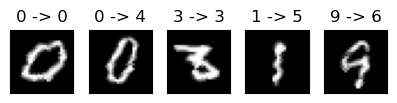

In [79]:
if __name__=='__main__':
  np.random.seed(42)
  torch.manual_seed(42)

  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
  testset = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
  test_loader = torch.utils.data.DataLoader(testset,batch_size=1,shuffle=True)

 
  model = Net().to(device)
  if device == "cpu":
    model.load_state_dict(torch.load("./model.pt", map_location='cpu'))
  else:
    model.load_state_dict(torch.load("./model.pt"))

  model.eval()

  adv=[]
  adv_label=[]
  correct_label=[]
  sample=5
  success=0
  for i,data in enumerate(test_loader):
    if i<sample:
      input,label = data[0].to(device),data[1].to(device)
      random_target = np.random.choice([num for num in range(10) if num != label.item()])
      target = torch.from_numpy(np.expand_dims(np.eye(10, dtype=np.float32)[random_target],0)).to(device)
      pert_out = attack(input,target,model,const=0.05,max_iter=1000)
      if pert_out!=None:
        output =  model(pert_out) 
        adv.append(pert_out.squeeze().detach().cpu().numpy())
        correct_label.append(label.item())
        adv_label.append(torch.argmax(output).item())
        if label.item()!=torch.argmax(output).item():
          success+=1
      print(f"process:{i+1}/{sample}")
    else:
      break

  print("Success Rate: {:.4f} ".format(success/sample))
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(adv)):
    cnt += 1
    if(cnt > 80):
      break
    plt.subplot(8,10,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    orig,adv_,ex = correct_label[i],adv_label[i],adv[i]
    plt.title("{} -> {}".format(orig, adv_))
    plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()



## 无目标攻击测试(尚不可用)  Untrgeted Attack(Not Finished)

In [86]:
if __name__=='__main__':
  np.random.seed(42)
  torch.manual_seed(42)

  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
  testset = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
  test_loader = torch.utils.data.DataLoader(testset,batch_size=1,shuffle=True)

 
  model = Net().to(device)
  if device == "cpu":
    model.load_state_dict(torch.load("./model.pt", map_location='cpu'))
  else:
    model.load_state_dict(torch.load("./model.pt"))

  model.eval()

  adv=[]
  adv_label=[]
  correct_label=[]
  sample=5
  success=0
  for i,data in enumerate(test_loader):
    if i<sample:
      input,label = data[0].to(device),data[1].to(device)
      untarget = torch.from_numpy(np.expand_dims(np.eye(10, dtype=np.float32)[label.cpu().item()],0)).to(device)
      pert_out = attack(input,untarget,model,const = 0.03,targeted=False,max_iter=2000)
      if pert_out!=None:
        output =  model(pert_out) 
        adv.append(pert_out.squeeze().detach().cpu().numpy())
        correct_label.append(label.item())
        adv_label.append(torch.argmax(output).item())
        if label.item()!=torch.argmax(output).item():
          success+=1
        print(f"process:{i+1}/{sample}")
    else:
      break

  print("Success Rate: {:.4f} ".format(success/sample))
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(adv)):
    cnt += 1
    if(cnt > 80):
      break
    plt.subplot(8,10,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    orig,adv_,ex = correct_label[i],adv_label[i],adv[i]
    plt.title("{} -> {}".format(orig, adv_))
    plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()



Step: 0, Loss: -0.0000,   flow Loss: 0.0000,    total Loss: 0.0000
Step: 100, Loss: -0.0000,   flow Loss: 0.0000,    total Loss: 0.0000
Step: 200, Loss: -0.0000,   flow Loss: 0.0000,    total Loss: 0.0000
Step: 300, Loss: -0.0000,   flow Loss: 0.0000,    total Loss: 0.0000


KeyboardInterrupt: 

In [96]:
output = model(data[0].to(device))
print(output)
print(untarget)
untarget[0][0] = 0
untarget[0][1] = 1
criterion = nn.CrossEntropyLoss() 
#print(criterion(output,torch.tensor([0]).to(device)))
print(criterion(output,untarget))
print(criterion(output,torch.tensor([1]).to(device)))

tensor([[ 36.9103,  -9.3370,   3.6370, -11.8285, -11.2563,  -9.9514,   0.9179,
          -4.4021,   4.1048,   1.5072]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
tensor(46.2474, device='cuda:0', grad_fn=<DivBackward1>)
tensor(46.2474, device='cuda:0', grad_fn=<NllLossBackward0>)
